In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import sys
import math
import torch
import time
import re
import cv2
import shutil
from pathlib import Path
from tqdm import tqdm
from matplotlib import pyplot as plt
from torchvision import transforms
from icecream import ic
import tensorflow as tf 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)
np.set_printoptions(precision=2,suppress=True)

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(device_type='GPU', devices=gpus[0])

# Tensorflow中的时间处理API

In [3]:
dataset = tf.data.Dataset.range(10)
for val in dataset:
    print(val.numpy())

0
1
2
3
4
5
6
7
8
9


2022-03-25 01:50:45.613170: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-25 01:50:46.676585: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 885 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:89:00.0, compute capability: 8.6
2022-03-25 01:50:46.677564: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46711 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:b1:00.0, compute capability: 8.6


In [4]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1)
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end=' ')
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 


2022-03-25 01:50:46.738534: W tensorflow/core/framework/dataset.cc:768] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


In [5]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end=' ')
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


In [6]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window:window.batch(5))
for window_dataset in dataset:
    print(window_dataset.numpy(), end=' ')
    

[0 1 2 3 4] [1 2 3 4 5] [2 3 4 5 6] [3 4 5 6 7] [4 5 6 7 8] [5 6 7 8 9] 

In [7]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window:window.batch(5))
dataset = dataset.map(lambda window:(window[:-1], window[-1:]))
for x, y in dataset:
    print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [8]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window:window.batch(5))
dataset = dataset.map(lambda window:(window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
for x, y in dataset:
    print(x.numpy(), y.numpy())

[5 6 7 8] [9]
[2 3 4 5] [6]
[0 1 2 3] [4]
[4 5 6 7] [8]
[3 4 5 6] [7]
[1 2 3 4] [5]


In [9]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window:window.batch(5))
dataset = dataset.map(lambda window:(window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)
for x, y in dataset:
    print(x.numpy(), y.numpy())

[[5 6 7 8]
 [1 2 3 4]] [[9]
 [5]]
[[4 5 6 7]
 [0 1 2 3]] [[8]
 [4]]
[[2 3 4 5]
 [3 4 5 6]] [[6]
 [7]]


In [32]:
def trend(time, slope=0):
    return slope * time
def plot_series(time, series, start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], label=label)
    plt.xlabel("time")
    plt.ylabel("value")
    if label:
        plt.legend(fontsize=14)
    plt.grid = True
def seasonal_pattern(season_time):
    return np.where(
        season_time < 0.4, np.cos(season_time * 2 * np.pi), 1 / np.exp(3 * season_time)
    )
def seasonality(time, period, amplititude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplititude * seasonal_pattern(season_time)
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series)-window_size):
        forecast.append(series[time: time + window_size].mean())
    return np.array(forecast)

<Figure size 720x432 with 0 Axes>

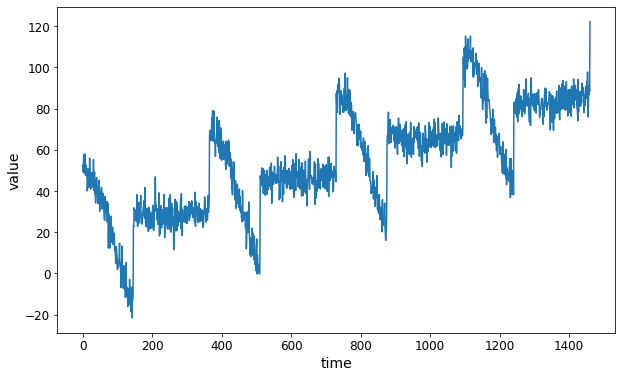

In [5]:
time = np.arange(365*4+1)
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.05
noise_level = 5
series = (
    baseline + trend(time, slope) + seasonality(time, period=365, amplititude=amplitude)
)
series += white_noise(time, noise_level, seed=42)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [4]:
len(series)

1461

In [6]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [7]:
def window_dataset(series, window_size, babtch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window:window.batch(window_size+1))
    dataset = dataset.map(lambda window:(window[:-1], window[-1:]))
    dataset = dataset.shuffle(buffer_size=10)
    dataset = dataset.batch(babtch_size).prefetch(1)
    return dataset

In [8]:
window_size = 20
batch_size = 10
train_dataset = window_dataset(x_train, window_size, batch_size)
train_dataset

2022-03-25 02:12:32.340607: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-25 02:12:32.927237: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46711 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:89:00.0, compute capability: 8.6


<PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None, None), dtype=tf.float64, name=None))>

In [9]:
for x, y in train_dataset:
    print(x.numpy().shape)
    print(y.numpy().shape)
#     break

(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 1)
(10, 20)
(10, 

# 使用深度网络处理序列

In [16]:
model = tf.keras.models.Sequential(
    tf.keras.layers.Dense(1, input_shape=[window_size])
)
model.summary()

model.compile(
    loss = 'mse',
    optimizer = tf.optimizers.SGD(learning_rate=1e-6, momentum=0.9),
    metrics=['accuracy'],
)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [14]:
for x, y in train_dataset:
    print(x.numpy().shape)
    print(y.numpy().shape)
    z = model(x)
    print(z.numpy().shape)
    break

(10, 20)
(10, 1)
(10, 1)


In [17]:
model.fit(train_dataset, epochs=100, verbose=1)

Epoch 1/100
98/98 [==============================] - 1s 3ms/step - loss: 2817.0000 - accuracy: 0.0000e+00
Epoch 2/100
98/98 [==============================] - 0s 2ms/step - loss: 99.0350 - accuracy: 0.0000e+00
Epoch 3/100
98/98 [==============================] - 0s 2ms/step - loss: 91.0605 - accuracy: 0.0000e+00
Epoch 4/100
98/98 [==============================] - 0s 3ms/step - loss: 86.2028 - accuracy: 0.0000e+00
Epoch 5/100
98/98 [==============================] - 0s 2ms/step - loss: 79.5087 - accuracy: 0.0000e+00
Epoch 6/100
98/98 [==============================] - 0s 3ms/step - loss: 75.7376 - accuracy: 0.0000e+00
Epoch 7/100
98/98 [==============================] - 0s 2ms/step - loss: 71.0880 - accuracy: 0.0000e+00
Epoch 8/100
98/98 [==============================] - 0s 3ms/step - loss: 69.4642 - accuracy: 0.0000e+00
Epoch 9/100
98/98 [==============================] - 0s 2ms/step - loss: 65.7804 - accuracy: 0.0000e+00
Epoch 10/100
98/98 [==============================] - 0s 2ms/s

98/98 [==============================] - 0s 3ms/step - loss: 44.6935 - accuracy: 0.0000e+00
Epoch 80/100
98/98 [==============================] - 0s 2ms/step - loss: 44.3500 - accuracy: 0.0000e+00
Epoch 81/100
98/98 [==============================] - 0s 3ms/step - loss: 44.3028 - accuracy: 0.0000e+00
Epoch 82/100
98/98 [==============================] - 0s 2ms/step - loss: 43.9883 - accuracy: 0.0000e+00
Epoch 83/100
98/98 [==============================] - 0s 3ms/step - loss: 45.4420 - accuracy: 0.0000e+00
Epoch 84/100
98/98 [==============================] - 0s 3ms/step - loss: 45.2262 - accuracy: 0.0000e+00
Epoch 85/100
98/98 [==============================] - 0s 2ms/step - loss: 44.9423 - accuracy: 0.0000e+00
Epoch 86/100
98/98 [==============================] - 0s 2ms/step - loss: 44.7280 - accuracy: 0.0000e+00
Epoch 87/100
98/98 [==============================] - 0s 2ms/step - loss: 44.5949 - accuracy: 0.0000e+00
Epoch 88/100
98/98 [==============================] - 0s 2ms/step - 

In [19]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time+ window_size][np.newaxis]))
forecast

[array([[43.16]], dtype=float32),
 array([[48.77]], dtype=float32),
 array([[48.59]], dtype=float32),
 array([[48.18]], dtype=float32),
 array([[44.34]], dtype=float32),
 array([[44.57]], dtype=float32),
 array([[44.97]], dtype=float32),
 array([[44.71]], dtype=float32),
 array([[45.61]], dtype=float32),
 array([[43.92]], dtype=float32),
 array([[44.62]], dtype=float32),
 array([[43.65]], dtype=float32),
 array([[48.55]], dtype=float32),
 array([[47.62]], dtype=float32),
 array([[44.05]], dtype=float32),
 array([[45.22]], dtype=float32),
 array([[42.82]], dtype=float32),
 array([[43.13]], dtype=float32),
 array([[39.72]], dtype=float32),
 array([[37.38]], dtype=float32),
 array([[39.49]], dtype=float32),
 array([[43.41]], dtype=float32),
 array([[42.93]], dtype=float32),
 array([[42.61]], dtype=float32),
 array([[39.97]], dtype=float32),
 array([[37.81]], dtype=float32),
 array([[37.14]], dtype=float32),
 array([[37.69]], dtype=float32),
 array([[40.17]], dtype=float32),
 array([[41.15

In [20]:
len(forecast)

1441

In [24]:
a = forecast[split_time-window_size:]
len(a)
b = series[time:time+ window_size][np.newaxis]
b
len(series)

461

array([[87.66, 90.25, 85.31, 77.96, 86.47, 81.25, 81.89, 87.5 , 90.79,
        84.74, 86.21, 93.21, 85.93, 97.77, 87.62, 76.02, 88.62, 86.8 ,
        91.37, 88.32]])

1461

In [30]:
result = forecast[split_time-window_size:]
result = np.array(result)[:,0,0]
result.shape
result

(461,)

array([ 63.96,  67.5 ,  68.76,  66.62,  63.1 ,  65.14,  65.15,  67.04,
        66.67,  67.09,  64.36,  68.07,  66.05,  70.37,  65.41,  69.43,
        65.53,  65.31,  62.04,  63.04,  63.02,  65.79,  63.02,  63.9 ,
        68.06,  71.35,  69.03,  66.08,  65.32,  66.44,  64.05,  62.37,
        58.65,  62.65,  64.27,  64.24,  66.87,  63.28,  60.51,  62.54,
        66.01,  69.81,  66.34,  66.86,  65.43,  65.61,  66.97,  66.8 ,
        62.14,  66.59,  68.77,  67.31,  64.99,  66.51,  65.87,  64.59,
        63.26,  63.5 ,  67.26,  67.26,  65.28,  66.52,  59.12,  64.66,
        61.03,  62.02,  59.54,  61.13,  63.36,  65.  ,  65.04,  65.15,
        65.74,  66.52,  63.03,  66.38,  64.56,  61.18,  62.32,  66.08,
        69.02,  66.92,  64.31,  64.54,  69.73,  70.31,  68.52,  68.53,
        68.47,  66.77,  66.33,  64.53,  65.6 ,  67.56,  66.78,  67.99,
        84.86,  94.68,  95.24, 100.48, 103.04, 107.73, 100.06, 105.44,
       103.54, 108.38, 102.3 , 105.26, 100.32, 102.59, 105.36, 106.45,
      

<Figure size 720x432 with 0 Axes>

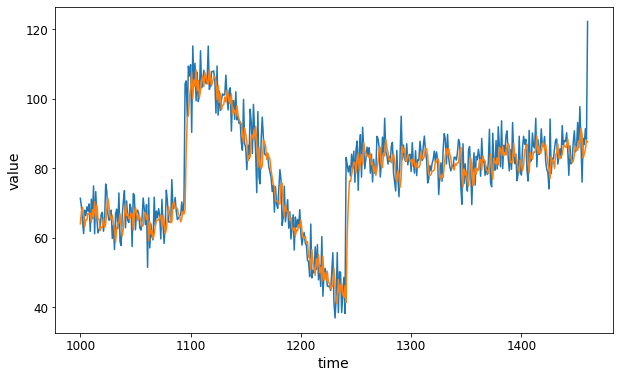

In [34]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, result)

In [36]:
tf.keras.metrics.mean_absolute_error(x_valid, result).numpy()
tf.keras.metrics.mean_squared_error(x_valid, result).numpy()

4.9527235

45.474174

## 2

In [54]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size],activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
]
)
model.summary()

model.compile(
    loss = 'mse',
    optimizer = tf.optimizers.SGD(learning_rate=1e-6, momentum=0.9),
)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 10)                210       
                                                                 
 dense_40 (Dense)            (None, 10)                110       
                                                                 
 dense_41 (Dense)            (None, 1)                 11        
                                                                 
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


In [55]:
model.fit(train_dataset, epochs=100, verbose=1)

Epoch 1/100
98/98 [==============================] - 0s 3ms/step - loss: 259.8543
Epoch 2/100
98/98 [==============================] - 0s 2ms/step - loss: 76.3228
Epoch 3/100
98/98 [==============================] - 0s 3ms/step - loss: 73.5810
Epoch 4/100
98/98 [==============================] - 0s 3ms/step - loss: 72.9223
Epoch 5/100
98/98 [==============================] - 0s 3ms/step - loss: 73.3598
Epoch 6/100
98/98 [==============================] - 0s 2ms/step - loss: 71.1242
Epoch 7/100
98/98 [==============================] - 0s 3ms/step - loss: 68.1987
Epoch 8/100
98/98 [==============================] - 0s 3ms/step - loss: 67.9560
Epoch 9/100
98/98 [==============================] - 0s 3ms/step - loss: 65.8094
Epoch 10/100
98/98 [==============================] - 0s 3ms/step - loss: 65.4036
Epoch 11/100
98/98 [==============================] - 0s 3ms/step - loss: 65.9300
Epoch 12/100
98/98 [==============================] - 0s 2ms/step - loss: 65.0413
Epoch 13/100
98/98 [====

In [56]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time+ window_size][np.newaxis]))
forecast

[array([[49.4]], dtype=float32),
 array([[50.92]], dtype=float32),
 array([[52.02]], dtype=float32),
 array([[51.51]], dtype=float32),
 array([[49.16]], dtype=float32),
 array([[48.86]], dtype=float32),
 array([[48.65]], dtype=float32),
 array([[48.84]], dtype=float32),
 array([[49.16]], dtype=float32),
 array([[47.12]], dtype=float32),
 array([[48.12]], dtype=float32),
 array([[46.83]], dtype=float32),
 array([[48.92]], dtype=float32),
 array([[50.92]], dtype=float32),
 array([[48.03]], dtype=float32),
 array([[48.59]], dtype=float32),
 array([[47.2]], dtype=float32),
 array([[47.9]], dtype=float32),
 array([[45.52]], dtype=float32),
 array([[44.9]], dtype=float32),
 array([[43.94]], dtype=float32),
 array([[45.65]], dtype=float32),
 array([[47.34]], dtype=float32),
 array([[44.85]], dtype=float32),
 array([[44.96]], dtype=float32),
 array([[42.92]], dtype=float32),
 array([[43.22]], dtype=float32),
 array([[42.9]], dtype=float32),
 array([[43.78]], dtype=float32),
 array([[45.3]], dt

In [57]:
result = forecast[split_time-window_size:]
result = np.array(result)[:,0,0]
result.shape
result

(461,)

array([ 66.52,  72.9 ,  71.23,  70.21,  67.8 ,  69.45,  68.18,  70.42,
        69.3 ,  69.68,  68.5 ,  70.91,  70.21,  73.74,  71.44,  72.3 ,
        69.94,  70.58,  68.93,  68.98,  68.82,  69.78,  68.61,  69.62,
        69.57,  74.81,  71.55,  71.07,  68.93,  72.14,  69.62,  68.93,
        65.77,  68.02,  68.07,  68.77,  69.73,  68.5 ,  67.91,  66.79,
        69.94,  73.97,  70.1 ,  69.36,  67.91,  70.1 ,  70.05,  70.26,
        68.55,  68.34,  71.82,  72.08,  69.03,  70.21,  70.75,  69.09,
        68.87,  70.32,  70.53,  71.76,  69.35,  70.32,  66.68,  69.35,
        67.96,  68.02,  66.2 ,  67.27,  67.8 ,  67.7 ,  69.89,  68.02,
        68.71,  70.26,  67.21,  71.12,  67.7 ,  68.5 ,  65.29,  68.77,
        72.27,  70.16,  68.18,  68.28,  71.76,  73.42,  72.46,  70.91,
        71.6 ,  71.92,  70.05,  70.16,  70.37,  71.6 ,  70.8 ,  71.23,
        90.11, 102.51, 105.43, 106.4 , 114.82, 120.86,  98.04, 113.72,
       114.28, 113.67, 100.65, 112.35, 105.69, 105.81, 111.34, 114.5 ,
      

<Figure size 720x432 with 0 Axes>

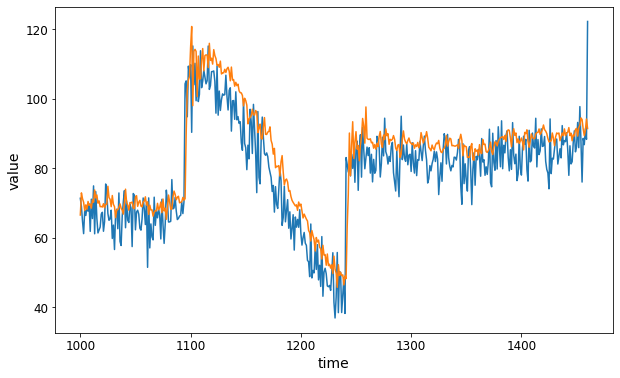

In [58]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, result)

In [59]:
tf.keras.metrics.mean_absolute_error(x_valid, result).numpy()
tf.keras.metrics.mean_squared_error(x_valid, result).numpy()

6.6268444

68.225716

In [65]:
model.compile(
    loss = 'mse',
    optimizer = tf.optimizers.SGD(learning_rate=1e-5, momentum=0.9),
)
history = model.fit(train_dataset, epochs=100, verbose=1)

Epoch 1/100
98/98 [==============================] - 1s 3ms/step - loss: 42.4138
Epoch 2/100
98/98 [==============================] - 0s 2ms/step - loss: 44.8053
Epoch 3/100
98/98 [==============================] - 0s 2ms/step - loss: 41.9531
Epoch 4/100
98/98 [==============================] - 0s 2ms/step - loss: 40.9307
Epoch 5/100
98/98 [==============================] - 0s 3ms/step - loss: 44.4186
Epoch 6/100
98/98 [==============================] - 0s 2ms/step - loss: 45.4279
Epoch 7/100
98/98 [==============================] - 0s 3ms/step - loss: 44.0084
Epoch 8/100
98/98 [==============================] - 0s 2ms/step - loss: 40.2937
Epoch 9/100
98/98 [==============================] - 0s 2ms/step - loss: 49.3255
Epoch 10/100
98/98 [==============================] - 0s 3ms/step - loss: 54.0485
Epoch 11/100
98/98 [==============================] - 0s 2ms/step - loss: 45.2968
Epoch 12/100
98/98 [==============================] - 0s 2ms/step - loss: 48.9745
Epoch 13/100
98/98 [=====

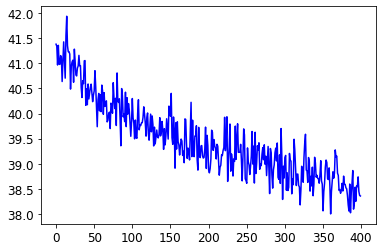

In [64]:
loss=history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='trainingloss')

In [67]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch:1e-8*10**(epoch/20))
history = model.fit(train_dataset, epochs=100, verbose=1, callbacks=[lr_scheduler])

Epoch 1/100
98/98 [==============================] - 0s 3ms/step - loss: 91.1434 - lr: 1.0000e-08
Epoch 2/100
98/98 [==============================] - 0s 3ms/step - loss: 62.8451 - lr: 1.1220e-08
Epoch 3/100
98/98 [==============================] - 0s 3ms/step - loss: 47.8592 - lr: 1.2589e-08
Epoch 4/100
98/98 [==============================] - 0s 3ms/step - loss: 41.5476 - lr: 1.4125e-08
Epoch 5/100
98/98 [==============================] - 0s 3ms/step - loss: 39.0548 - lr: 1.5849e-08
Epoch 6/100
98/98 [==============================] - 0s 3ms/step - loss: 38.1340 - lr: 1.7783e-08
Epoch 7/100
98/98 [==============================] - 0s 3ms/step - loss: 37.8223 - lr: 1.9953e-08
Epoch 8/100
98/98 [==============================] - 0s 3ms/step - loss: 37.6897 - lr: 2.2387e-08
Epoch 9/100
98/98 [==============================] - 0s 3ms/step - loss: 37.6480 - lr: 2.5119e-08
Epoch 10/100
98/98 [==============================] - 0s 3ms/step - loss: 37.6180 - lr: 2.8184e-08
Epoch 11/100
98/98 

98/98 [==============================] - 0s 3ms/step - loss: 508.1606 - lr: 1.2589e-04
Epoch 84/100
98/98 [==============================] - 0s 3ms/step - loss: 482.3658 - lr: 1.4125e-04
Epoch 85/100
98/98 [==============================] - 0s 3ms/step - loss: 466.6295 - lr: 1.5849e-04
Epoch 86/100
98/98 [==============================] - 0s 3ms/step - loss: 458.1582 - lr: 1.7783e-04
Epoch 87/100
98/98 [==============================] - 0s 3ms/step - loss: 454.5559 - lr: 1.9953e-04
Epoch 88/100
98/98 [==============================] - 0s 3ms/step - loss: 453.8794 - lr: 2.2387e-04
Epoch 89/100
98/98 [==============================] - 0s 3ms/step - loss: 454.8674 - lr: 2.5119e-04
Epoch 90/100
98/98 [==============================] - 0s 3ms/step - loss: 456.7733 - lr: 2.8184e-04
Epoch 91/100
98/98 [==============================] - 0s 3ms/step - loss: 458.8646 - lr: 3.1623e-04
Epoch 92/100
98/98 [==============================] - 0s 3ms/step - loss: 461.1233 - lr: 3.5481e-04
Epoch 93/100


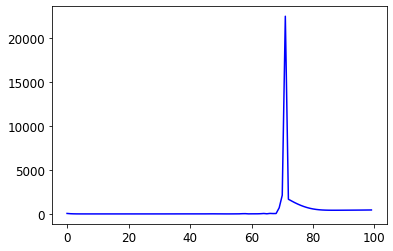

In [68]:
loss=history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='trainingloss')

# 使用RNN处理时间序列

In [69]:
for x, y in train_dataset.take(1).as_numpy_iterator():
    print(x.shape, y.shape)

(10, 20) (10, 1)


In [71]:
tf.expand_dims(x, axis=-1)

<tf.Tensor: shape=(10, 20, 1), dtype=float64, numpy=
array([[[52.68],
        [47.59],
        [47.51],
        [50.96],
        [40.09],
        [40.92],
        [46.61],
        [44.23],
        [50.72],
        [44.45],
        [41.77],
        [55.98],
        [47.34],
        [48.6 ],
        [40.93],
        [45.11],
        [48.16],
        [41.61],
        [48.99],
        [43.84]],

       [[47.59],
        [47.51],
        [50.96],
        [40.09],
        [40.92],
        [46.61],
        [44.23],
        [50.72],
        [44.45],
        [41.77],
        [55.98],
        [47.34],
        [48.6 ],
        [40.93],
        [45.11],
        [48.16],
        [41.61],
        [48.99],
        [43.84],
        [45.11]],

       [[48.93],
        [57.98],
        [53.9 ],
        [47.67],
        [52.68],
        [47.59],
        [47.51],
        [50.96],
        [40.09],
        [40.92],
        [46.61],
        [44.23],
        [50.72],
        [44.45],
        [41.77],
        

In [87]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
    tf.keras.layers.GRU(10, return_sequences=True), 
#     tf.keras.layers.GRU(10),
#     tf.keras.layers.Dense(1)
]
)
model.build()
model.summary()

ValueError: You must provide an `input_shape` argument.

In [75]:
# x.shape

(10, 20)

In [96]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
#     tf.keras.layers.GRU(10, return_sequences=True), 
    tf.keras.layers.GRU(10),
#     tf.keras.layers.Dense(1)
]
)
# model1.summary()
y1 = model1(x)
y1.shape

TensorShape([10, 10])

In [99]:
model1 = tf.keras.layers.GRU(10)
x1 = tf.random.normal([2,3,4], 0, 1, tf.float32)
x1
# model1.summary()
y1 = model1(x1)
y1.shape

<tf.Tensor: shape=(2, 3, 4), dtype=float32, numpy=
array([[[-0.78, -0.42, -0.93,  0.26],
        [ 0.3 ,  0.64, -2.36, -0.9 ],
        [ 1.41,  0.01,  1.13, -2.06]],

       [[-0.84,  0.06,  0.6 , -0.19],
        [-0.06, -1.62,  1.37, -0.07],
        [ 0.87,  0.21, -1.61, -0.34]]], dtype=float32)>

TensorShape([2, 10])

In [100]:
model1 = tf.keras.layers.GRU(10, return_sequences=True)
x1 = tf.random.normal([2,3,4], 0, 1, tf.float32)
x1
# model1.summary()
y1 = model1(x1)
y1.shape

<tf.Tensor: shape=(2, 3, 4), dtype=float32, numpy=
array([[[ 0.15,  1.07, -1.  , -0.89],
        [-0.47, -0.76, -1.04,  1.07],
        [-0.87, -1.43, -0.52,  1.36]],

       [[ 0.57,  0.92, -1.87,  0.74],
        [-0.4 , -2.06,  0.64,  1.83],
        [ 1.17,  0.81,  0.64, -0.04]]], dtype=float32)>

TensorShape([2, 3, 10])

In [102]:
model1 = tf.keras.layers.GRU(10, return_state=True)
x1 = tf.random.normal([2,3,4], 0, 1, tf.float32)
x1
# model1.summary()
y1, y2 = model1(x1)
y1.shape, y2.shape

<tf.Tensor: shape=(2, 3, 4), dtype=float32, numpy=
array([[[-0.3 , -0.41, -0.33,  0.92],
        [ 1.47,  0.42, -0.44,  1.3 ],
        [ 0.69, -2.5 , -0.66, -1.73]],

       [[-0.61,  0.33, -0.4 ,  1.43],
        [-0.64,  1.63, -2.66,  0.54],
        [ 1.89,  0.07, -1.34,  0.39]]], dtype=float32)>

(TensorShape([2, 10]), TensorShape([2, 10]))

In [104]:
model1 = tf.keras.layers.GRU(10, return_state=True, return_sequences=True)
x1 = tf.random.normal([2,3,4], 0, 1, tf.float32)
x1
# model1.summary()
y1, y2 = model1(x1)
y1.shape, y2.shape

<tf.Tensor: shape=(2, 3, 4), dtype=float32, numpy=
array([[[-1.04,  0.02,  0.87,  1.36],
        [ 0.17,  1.76, -0.05, -0.31],
        [ 0.48,  0.7 ,  0.12,  0.97]],

       [[-0.42,  1.81, -0.09,  0.16],
        [-0.81,  1.89, -0.64, -0.28],
        [-1.14, -0.54,  0.74,  0.42]]], dtype=float32)>

(TensorShape([2, 3, 10]), TensorShape([2, 10]))

In [110]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
    tf.keras.layers.GRU(10, return_sequences=True),
    tf.keras.layers.GRU(10),
    tf.keras.layers.Dense(1)
]
)
# model.summary()

model.compile(
    loss='mse',
    optimizer=tf.optimizers.SGD(learning_rate=1e-6, momentum=0.9),
)
history=model.fit(train_dataset, epochs=100, verbose=1)

Epoch 1/100
98/98 [==============================] - 3s 8ms/step - loss: 2166.6218
Epoch 2/100
98/98 [==============================] - 1s 8ms/step - loss: 2112.7861
Epoch 3/100
98/98 [==============================] - 1s 8ms/step - loss: 2057.0649
Epoch 4/100
98/98 [==============================] - 1s 8ms/step - loss: 2002.1416
Epoch 5/100
98/98 [==============================] - 1s 8ms/step - loss: 1946.7944
Epoch 6/100
98/98 [==============================] - 1s 8ms/step - loss: 1890.9127
Epoch 7/100
98/98 [==============================] - 1s 8ms/step - loss: 1834.8851
Epoch 8/100
98/98 [==============================] - 1s 8ms/step - loss: 1779.2616
Epoch 9/100
98/98 [==============================] - 1s 8ms/step - loss: 1724.5494
Epoch 10/100
98/98 [==============================] - 1s 8ms/step - loss: 1671.1290
Epoch 11/100
98/98 [==============================] - 1s 8ms/step - loss: 1619.2440
Epoch 12/100
98/98 [==============================] - 1s 8ms/step - loss: 1569.0443
E

98/98 [==============================] - 1s 8ms/step - loss: 312.7363
Epoch 100/100
98/98 [==============================] - 1s 8ms/step - loss: 310.4476


In [106]:
# model.fit(train_dataset, epochs=100, verbose=1)

In [111]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time+ window_size][np.newaxis]))
# forecast

In [112]:
result = forecast[split_time-window_size:]
result = np.array(result)[:,0,0]
result.shape
result

(461,)

array([39.53, 39.53, 39.53, 39.53, 39.52, 39.53, 39.53, 39.53, 39.53,
       39.53, 39.52, 39.53, 39.53, 39.53, 39.52, 39.53, 39.53, 39.52,
       39.52, 39.52, 39.53, 39.53, 39.52, 39.52, 39.53, 39.53, 39.53,
       39.53, 39.53, 39.53, 39.52, 39.52, 39.52, 39.52, 39.53, 39.52,
       39.53, 39.52, 39.52, 39.52, 39.53, 39.53, 39.53, 39.53, 39.53,
       39.53, 39.53, 39.53, 39.52, 39.53, 39.53, 39.52, 39.53, 39.53,
       39.53, 39.52, 39.52, 39.52, 39.53, 39.53, 39.53, 39.53, 39.52,
       39.52, 39.52, 39.52, 39.52, 39.52, 39.53, 39.53, 39.53, 39.53,
       39.53, 39.53, 39.52, 39.53, 39.53, 39.52, 39.52, 39.53, 39.53,
       39.53, 39.53, 39.53, 39.53, 39.53, 39.53, 39.53, 39.53, 39.53,
       39.53, 39.53, 39.53, 39.53, 39.53, 39.53, 39.53, 39.53, 39.53,
       39.53, 39.53, 39.53, 39.53, 39.53, 39.53, 39.53, 39.53, 39.53,
       39.53, 39.53, 39.53, 39.53, 39.53, 39.53, 39.53, 39.53, 39.53,
       39.53, 39.53, 39.53, 39.53, 39.53, 39.53, 39.53, 39.53, 39.53,
       39.53, 39.53,

<Figure size 720x432 with 0 Axes>

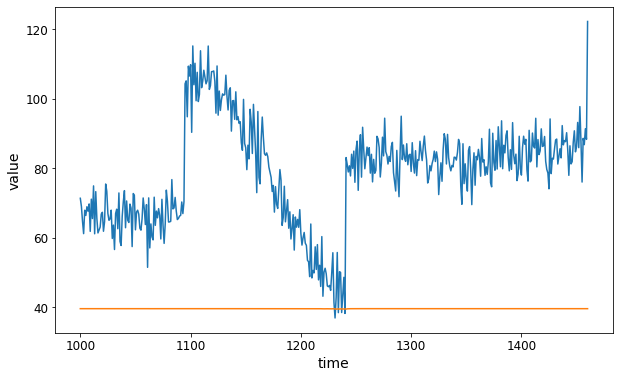

In [113]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, result)

In [59]:
tf.keras.metrics.mean_absolute_error(x_valid, result).numpy()
tf.keras.metrics.mean_squared_error(x_valid, result).numpy()

6.6268444

68.225716

In [65]:
model.compile(
    loss = 'mse',
    optimizer = tf.optimizers.SGD(learning_rate=1e-5, momentum=0.9),
)
history = model.fit(train_dataset, epochs=100, verbose=1)

Epoch 1/100
98/98 [==============================] - 1s 3ms/step - loss: 42.4138
Epoch 2/100
98/98 [==============================] - 0s 2ms/step - loss: 44.8053
Epoch 3/100
98/98 [==============================] - 0s 2ms/step - loss: 41.9531
Epoch 4/100
98/98 [==============================] - 0s 2ms/step - loss: 40.9307
Epoch 5/100
98/98 [==============================] - 0s 3ms/step - loss: 44.4186
Epoch 6/100
98/98 [==============================] - 0s 2ms/step - loss: 45.4279
Epoch 7/100
98/98 [==============================] - 0s 3ms/step - loss: 44.0084
Epoch 8/100
98/98 [==============================] - 0s 2ms/step - loss: 40.2937
Epoch 9/100
98/98 [==============================] - 0s 2ms/step - loss: 49.3255
Epoch 10/100
98/98 [==============================] - 0s 3ms/step - loss: 54.0485
Epoch 11/100
98/98 [==============================] - 0s 2ms/step - loss: 45.2968
Epoch 12/100
98/98 [==============================] - 0s 2ms/step - loss: 48.9745
Epoch 13/100
98/98 [=====

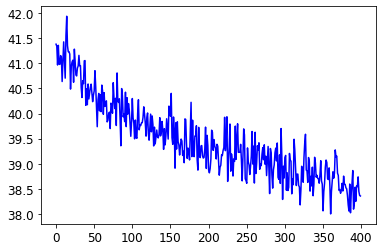

In [64]:
loss=history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='trainingloss')

In [67]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch:1e-8*10**(epoch/20))
history = model.fit(train_dataset, epochs=100, verbose=1, callbacks=[lr_scheduler])

Epoch 1/100
98/98 [==============================] - 0s 3ms/step - loss: 91.1434 - lr: 1.0000e-08
Epoch 2/100
98/98 [==============================] - 0s 3ms/step - loss: 62.8451 - lr: 1.1220e-08
Epoch 3/100
98/98 [==============================] - 0s 3ms/step - loss: 47.8592 - lr: 1.2589e-08
Epoch 4/100
98/98 [==============================] - 0s 3ms/step - loss: 41.5476 - lr: 1.4125e-08
Epoch 5/100
98/98 [==============================] - 0s 3ms/step - loss: 39.0548 - lr: 1.5849e-08
Epoch 6/100
98/98 [==============================] - 0s 3ms/step - loss: 38.1340 - lr: 1.7783e-08
Epoch 7/100
98/98 [==============================] - 0s 3ms/step - loss: 37.8223 - lr: 1.9953e-08
Epoch 8/100
98/98 [==============================] - 0s 3ms/step - loss: 37.6897 - lr: 2.2387e-08
Epoch 9/100
98/98 [==============================] - 0s 3ms/step - loss: 37.6480 - lr: 2.5119e-08
Epoch 10/100
98/98 [==============================] - 0s 3ms/step - loss: 37.6180 - lr: 2.8184e-08
Epoch 11/100
98/98 

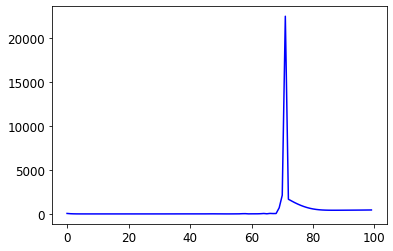

In [68]:
loss=history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='trainingloss')